In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



/home/kevin-desktop/anaconda3/envs/DS10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [52]:
df = pd.read_pickle("../data/dataframes/SDG/all_sdg_fixed_dst.pkl")

In [53]:
df = df[df["DST"]]

In [54]:
cond_iot_7 = df['AI'] & df['SDG13']
df = df[cond_iot_7]
df['TXT'] = df['AB'] +" "+ df['TI'] +" "+ df ['DE']

data = df.TXT.values.tolist()

In [55]:
df

,PT,AU,TI,SO,DE,AB,C1,EM,TC,PY,...,computing_infrastructure,blockchain,robotics,additive_manufacturing,Society,Economy,Environment,EU,DST,TXT
49429,J,"Hickman, E; Petrin, M",Trustworthy AI and Corporate Governance: The E...,EUROPEAN BUSINESS ORGANIZATION LAW REVIEW,Corporate governance; Artificial intelligence;...,AI will change many aspects of the world we li...,"[Hickman, Eleanore] Univ Bristol, Bristol, Avo...",eleanore.hickman@bristol.ac.uk; mpetrin@uwo.ca,0,2021,...,False,False,False,False,True,True,True,True,True,AI will change many aspects of the world we li...
50402,C,"Hernandez-Alvarez, M",Detection of possible human trafficking in Twi...,2019 INTERNATIONAL CONFERENCE ON INFORMATION S...,Human trafficking; deception detection; social...,"Social networks in general and Twitter, in par...","[Hernandez-Alvarez, Myriam] Escuela Politec Na...",NaN,2,2019,...,False,False,False,False,True,True,True,False,True,"Social networks in general and Twitter, in par..."
50404,J,"Volodko, A; Cockbain, E; Kleinberg, B","""Spotting the signs"" of trafficking recruitmen...",TRENDS IN ORGANIZED CRIME,Human trafficking; Labour trafficking; Labour ...,Despite considerable concern about how human t...,"[Volodko, Ada; Cockbain, Ella; Kleinberg, Benn...",ada.volodko@gmail.com,3,2020,...,False,False,False,False,True,True,True,True,True,Despite considerable concern about how human t...
50599,C,"Fernandez, ZAM; Cruz, MAT; Penaloza, C; Morgan...",Challenges of Smart Cities: How Smartphone App...,2020 THE 4TH INTERNATIONAL CONFERENCE ON SMART...,Smart Cities; Artificial Intelligence; Safety;...,Smart cities promote the use of emerging techn...,"[Fernandez, Zully Amairany Montiel; Cruz, Mari...",NaN,0,2020,...,False,False,False,False,True,True,True,False,True,Smart cities promote the use of emerging techn...
50816,J,"Yen, CP; Hung, TW",Achieving Equity with Predictive Policing Algo...,SCIENCE AND ENGINEERING ETHICS,Predictive policing algorithm; Artificial inte...,Whereas using artificial intelligence (AI) to ...,"[Yen, Chun-Ping; Hung, Tzu-Wei] Acad Sinica, I...",chunping.yen@gmail.com; htw@sinica.edu.tw,0,2021,...,False,False,False,False,True,True,True,False,True,Whereas using artificial intelligence (AI) to ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806580,C,"White, C",Data Science from the Lab to the Field to the ...,KDD'15: PROCEEDINGS OF THE 21ST ACM SIGKDD INT...,Open Source Tools; Data Mining Applications,DARPA has been investing in data science and b...,"[White, Christopher] Microsoft Corp, Redmond, ...",chwh@microsoft.com,1,2015,...,False,False,False,False,False,True,True,False,True,DARPA has been investing in data science and b...
807053,C,"Torres, EA; Granizo, SL; Hernandez-Alvarez, M",Gender and age classification based on human f...,2019 6TH INTERNATIONAL CONFERENCE ON COMPUTATI...,gender classification; age group recognition; ...,We developed a method to recognize gender and ...,"[Torres, Edgar A.; Granizo, Sergio L.; Hernand...",NaN,2,2019,...,False,False,False,False,False,True,True,False,True,We developed a method to recognize gender and ...
807136,C,"Robinson, JP; Shao, M; Fu, Y",To Recognize Families In the Wild: A Machine V...,PROCEEDINGS OF THE 2018 ACM MULTIMEDIA CONFERE...,Visual kinship understanding; family recogniti...,Automatic kinship recognition has relevance in...,"[Robinson, Joseph P.; Fu, Yun] Northeastern Un...",jrobins1@ece.neu.edu; mshao@umassd.edu; yunfu@...,0,2018,...,False,False,False,False,False,True,True,False,True,Automatic kinship recognition has relevance in...
807366,J,"Le, AD; McGuinness, JPL; Dixon, E",ChunkedHCs algorithm for authorship verificati...,FORENSIC SCIENCE INTERNATIONAL-DIGITAL INVESTI...,Authorship verification; Higher criticism; HC-...,Cybercrime can be associated with undisclosed ...,"[Le, Anh Duc; McGuinness, Justin P. L.] Munste...",dukele35@gmail.com,0,2021,...,False,False,False,False,False,True,True,True,True,Cybercrime can be associated 

In [56]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])



[['ai', 'will', 'change', 'many', 'aspects', 'of', 'the', 'world', 'we', 'live', 'in', 'including', 'the', 'way', 'corporations', 'are', 'governed', 'many', 'efficiencies', 'and', 'improvements', 'are', 'likely', 'but', 'there', 'are', 'also', 'potential', 'dangers', 'including', 'the', 'threat', 'of', 'harmful', 'impacts', 'on', 'third', 'parties', 'discriminatory', 'practices', 'data', 'and', 'privacy', 'breaches', 'fraudulent', 'practices', 'and', 'even', 'rogue', 'ai', 'to', 'address', 'these', 'dangers', 'the', 'eu', 'published', 'the', 'expert', 'group', 'policy', 'and', 'investment', 'recommendations', 'for', 'trustworthy', 'ai', 'the', 'guidelines', 'the', 'guidelines', 'produce', 'seven', 'principles', 'from', 'its', 'four', 'foundational', 'pillars', 'of', 'respect', 'for', 'human', 'autonomy', 'prevention', 'of', 'harm', 'fairness', 'and', 'explicability', 'if', 'implemented', 'by', 'business', 'the', 'impact', 'on', 'corporate', 'governance', 'will', 'be', 'substantial', 'f

In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



['ai', 'will', 'change', 'many_aspects', 'of', 'the', 'world', 'we', 'live', 'in', 'including', 'the', 'way', 'corporations', 'are', 'governed', 'many', 'efficiencies', 'and', 'improvements', 'are_likely', 'but', 'there_are', 'also', 'potential', 'dangers', 'including', 'the', 'threat', 'of', 'harmful', 'impacts_on', 'third', 'parties', 'discriminatory', 'practices', 'data', 'and', 'privacy', 'breaches', 'fraudulent', 'practices', 'and', 'even', 'rogue', 'ai', 'to_address', 'these', 'dangers', 'the', 'eu', 'published', 'the', 'expert', 'group', 'policy', 'and', 'investment', 'recommendations', 'for', 'trustworthy', 'ai', 'the', 'guidelines', 'the', 'guidelines', 'produce', 'seven', 'principles', 'from', 'its', 'four', 'foundational', 'pillars', 'of', 'respect', 'for', 'human', 'autonomy', 'prevention', 'of', 'harm', 'fairness', 'and', 'explicability', 'if', 'implemented', 'by', 'business', 'the', 'impact_on', 'corporate_governance', 'will_be', 'substantial', 'fundamental', 'questions',

In [58]:
# spacy stopwords
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
print(len(all_stopwords))
all_stopwords.update(["technology", "use","uses", "used", "model", "models", "system","systems", "base","based","bases", "high", "index","approach",
                      "information", "datum", "basis", "process", "tool","new", "problem", "result", "results", "resource",
                      "method", "image", "study", "feature", "technique", "different", "test", "low", "low", "class", "analysis",
                      "paper", "provide", "provides", "provided", "data", "increase", "increases", "increased", "propose", "proposes",
                     "proposed", "feature", "features", "big", "level", 'object', "levels", "objects", "method","methods",
                     "modelled", "modeled", "modelling", "modeling", "large", "case", "cases", "present", "presents", "consider",
                     "considering", "considered", "prediction", "predicts", "predict", "predicted", "compare", "compares", "compared",
                     "comparing", "improve", "improves", "improving", "improved", "estimate", "estimating", "estimates", "estimated",
                     "network", "networks", "control", "controls", "controlled", "controlling", "include", "includes", "including",
                     "included", "show", "shows", "showed", "showing", "important", "high", "develop", "develops", "developed", "developing",
                     "change", "changes", "changed", "changing", "performance", "apply", "applies", "applied", "applying",
                     "observe", "observes", "observing", "observed", "lean", "learns", "learned", "value", "obtain", "obtained",
                     "obtains", "obtained", "indicate", "indicates", "indicating","indicated", "application", "applications", "reduce", "time", "design", "research", "management"])
print(len(all_stopwords))



462
462


In [59]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/home/kevin-desktop/anaconda3/envs/DS10/lib/python3.10/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [60]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)



# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])



[['aspect', 'world', 'live', 'way', 'corporation', 'govern', 'efficiency', 'improvement', 'likely', 'potential', 'danger', 'threat', 'harmful', 'impact', 'party', 'discriminatory', 'practice', 'privacy', 'breach', 'fraudulent', 'practice', 'rogue', 'ai', 'publish', 'expert', 'group', 'policy', 'investment', 'recommendation', 'trustworthy', 'ai', 'guideline', 'guideline', 'produce', 'principle', 'foundational', 'pillar', 'respect', 'human', 'autonomy', 'prevention', 'harm', 'fairness', 'explicability', 'implement', 'business', 'impact', 'corporate_governance', 'substantial', 'fundamental', 'question', 'intersection', 'ethic', 'law', 'guideline', 'address', 'reference', 'practical', 'challenge', 'business', 'promote', 'positive', 'corporate_governance', 'principle', 'stakeholder', 'orient', 'human', 'centric', 'corporate', 'purpose', 'diversity', 'fairness', 'clear', 'general', 'nature', 'leave', 'question', 'concern', 'unanswered', 'examine', 'potential', 'significance', 'impact', 'guid

In [61]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])


In [62]:


# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]



[[('address', 1),
  ('ai', 3),
  ('aspect', 1),
  ('autonomy', 1),
  ('breach', 1),
  ('business', 3),
  ('centric', 1),
  ('challenge', 1),
  ('clear', 1),
  ('company', 3),
  ('concern', 1),
  ('conclude', 1),
  ('corporate', 2),
  ('corporate_governance', 3),
  ('corporation', 1),
  ('danger', 1),
  ('direct', 1),
  ('discriminatory', 1),
  ('diversity', 1),
  ('efficiency', 1),
  ('emerge', 1),
  ('establish', 1),
  ('ethic', 2),
  ('european_union', 1),
  ('examine', 1),
  ('expert', 1),
  ('explicability', 1),
  ('fairness', 2),
  ('foundational', 1),
  ('fraudulent', 1),
  ('fundamental', 1),
  ('general', 1),
  ('govern', 1),
  ('governance', 2),
  ('group', 1),
  ('guideline', 6),
  ('hard', 1),
  ('harm', 1),
  ('harmful', 1),
  ('harmonise', 1),
  ('human', 2),
  ('impact', 3),
  ('imperfection', 1),
  ('implement', 1),
  ('improvement', 1),
  ('instrument', 1),
  ('intersection', 1),
  ('investment', 1),
  ('issue', 1),
  ('law', 5),
  ('leave', 1),
  ('legislative', 1),
  

In [63]:
all_stopwords

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'analysis',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'application',
 'applications',
 'applied',
 'applies',
 'apply',
 'applying',
 'approach',
 'are',
 'around',
 'as',
 'at',
 'authors_publishe',
 'back',
 'base',
 'based',
 'bases',
 'basis',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'big',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'case',
 'cases',
 'change',
 'changed',
 'changes',
 'changing',
 'class',
 'classification_accuracy',
 'compare',
 'compared',
 'compares',
 'comparing',
 'consider',
 'considered',
 'co

In [64]:
all_stopwords.update(
    {"rights_reserve", "decision_make", "decision_maker", "principal_component", "recent_year", "spatial_revolution",
     "authors_publishe", "classification_accuracy"}
)
all_stopwords

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'analysis',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'application',
 'applications',
 'applied',
 'applies',
 'apply',
 'applying',
 'approach',
 'are',
 'around',
 'as',
 'at',
 'authors_publishe',
 'back',
 'base',
 'based',
 'bases',
 'basis',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'big',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'case',
 'cases',
 'change',
 'changed',
 'changes',
 'changing',
 'class',
 'classification_accuracy',
 'compare',
 'compared',
 'compares',
 'comparing',
 'consider',
 'considered',
 'co

In [65]:
from collections import Counter

frequencies = Counter()
frequencies_ngram = Counter()
stuff = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
for i, tok in enumerate(stuff):
    for tup in tok:
        if tup[0] not in all_stopwords:
            if "_" in tup[0]:
                frequencies_ngram[tup[0]] += 1
            frequencies[tup[0]] +=1


print(frequencies_ngram.most_common(10))


[('machine_learne', 1005), ('artificial_neural', 870), ('machine_learning', 783), ('remote_sense', 474), ('deep_learning', 368), ('environmental_impact', 328), ('global_warming', 238), ('root_mean_square_error', 229), ('water_resource', 216), ('energy_consumption', 215)]


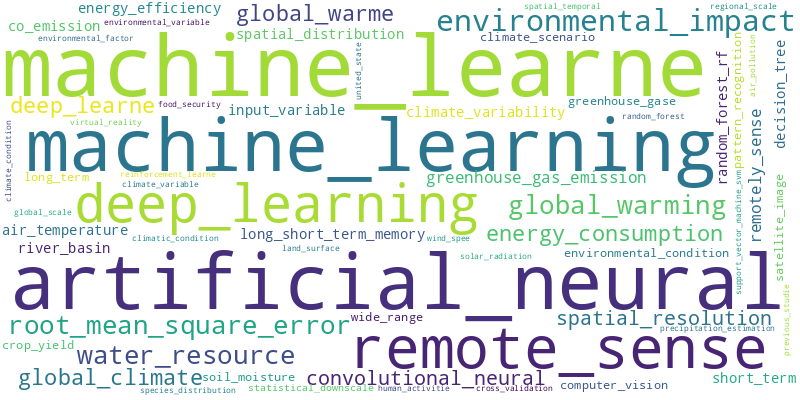

In [66]:


# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100, scale=2)
wordcloud.generate_from_frequencies(frequencies_ngram)

wordcloud.to_file("../img/Commission/wordcloud_ai_13.jpg", )
wordcloud.to_image()



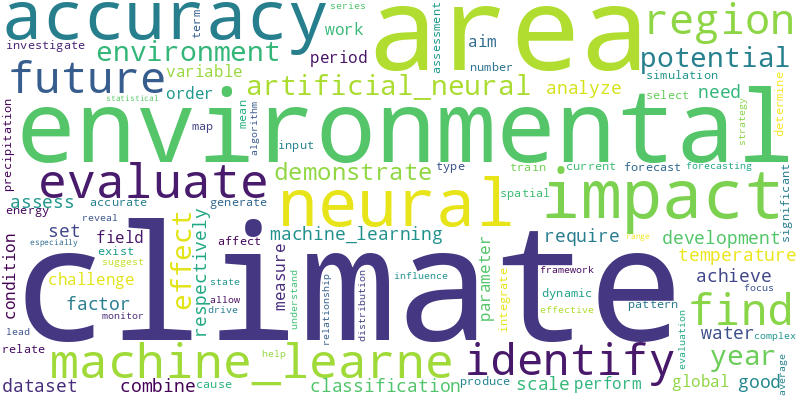

In [69]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100, scale=2)
wordcloud.generate_from_frequencies(frequencies)
wordcloud.to_image()
wordcloud.to_file("../img/Commission/wordcloud_ai_13_less_bigram.jpg")
wordcloud.to_image()